# InsideAirbnb - London 

### Questions discussed in this report: 
1. Is Airbnb “out of control” in London?

2. How many professional landlords are there?

3. How many properties would be affected by the opposition’s proposal?

4. What are the likely pros and cons of the opposition’s proposal? (for the Mayor, for the residents, for the city)

5. Can the story be reframed as a positive one about social mobility or housing opportunity?


## 1. EDA

### 1.0. Caching Remote Data

In [39]:
# Import libraries needed for this analysis
from pathlib import Path
from requests import get
from functools import wraps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager

In [40]:
def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

### 1.1. Data Loading

#### 1.1.0 Read Data

In this section, we read data remotely with the caching function above.

In [264]:
# Set download URL
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

# Read csv data
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [174]:
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

+ data/geo/Boroughs.gpkg?raw=true found locally!
+ data/geo/Water.gpkg?raw=true found locally!
+ data/geo/Greenspace.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Water.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Greenspace.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


#### 1.1.1 Save Raw Data
Then, we want to save the raw Data in case we need them again in the later exploring.

In [175]:
# Create a diractory for raw data
path = Path(f'data/raw/{Path(url).name}') 
print(f"Writing to: {path}")

# Save raw data locally
if not path.parent.exists(): 
    print(f"Creating {path.parent}")
    path.parent.mkdir(parents=True, exist_ok=True)

if not path.exists():  
    df.to_csv(path, index=False)
    print("Done.")

Writing to: data/raw/20250615-London-listings.csv.gz


### 1.2 Data Processing

#### 1.2.0. Info

We run the chunk below to have a general sense of what are in the raw data, such as data type and columns.

In [202]:
# Get the information of the whole data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96651 non-null  int64  
 1   listing_url                                   96651 non-null  object 
 2   scrape_id                                     96651 non-null  int64  
 3   last_scraped                                  96651 non-null  object 
 4   source                                        96651 non-null  object 
 5   name                                          96651 non-null  object 
 6   description                                   93806 non-null  object 
 7   neighborhood_overview                         41983 non-null  object 
 8   picture_url                                   96642 non-null  object 
 9   host_id                                       96651 non-null 

In [203]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.665100e+04,9.665100e+04,9.665100e+04,96613.000000,96613.000000,0.0,96651.000000,96651.000000,96651.000000,62730.000000,...,71443.000000,71466.000000,71442.000000,71442.000000,0.0,96651.000000,96651.000000,96651.000000,96651.000000,71487.000000
mean,6.526020e+17,2.025061e+13,2.091790e+08,46.263577,76.334945,NaN,51.509818,-0.127087,3.316520,1.358018,...,4.792937,4.816368,4.733591,4.623804,NaN,16.389370,14.170831,2.164716,0.025763,0.958877
std,5.708808e+17,0.000000e+00,2.141266e+08,357.645418,561.614957,NaN,0.048945,0.100853,2.073674,0.725580,...,0.431668,0.423297,0.408804,0.506245,NaN,53.299577,52.845630,8.543681,0.626042,1.282595
min,1.391300e+04,2.025061e+13,2.594000e+03,1.000000,1.000000,NaN,51.295937,-0.496760,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.955518e+07,2.025061e+13,2.673176e+07,1.000000,1.000000,NaN,51.484240,-0.189060,2.000000,1.000000,...,4.760000,4.800000,4.650000,4.500000,NaN,1.000000,0.000000,0.000000,0.000000,0.150000
50%,8.123206e+17,2.025061e+13,1.128684e+08,2.000000,3.000000,NaN,51.513791,-0.126990,2.000000,1.000000,...,4.930000,4.970000,4.850000,4.750000,NaN,2.000000,1.000000,0.000000,0.000000,0.500000
75%,1.197378e+18,2.025061e+13,4.063762e+08,9.000000,14.000000,NaN,51.539099,-0.067880,4.000000,1.500000,...,5.000000,5.000000,5.000000,4.950000,NaN,8.000000,5.000000,1.000000,0.000000,1.230000
max,1.439673e+18,2.025061e+13,7.001298e+08,4884.000000,8723.000000,NaN,51.682630,0.278960,16.000000,26.000000,...,5.000000,5.000000,5.000000,5.000000,NaN,495.000000,495.000000,116.000000,25.000000,38.410000


#### 1.2.1. Columns

In [240]:
# Check columns in the data set
print(df.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Given the result of columns above, we can tell there are many columns which are not useful for this analysis, therefore, we got `cols` below by copying the output of (`df.columns.to_list()`) and then removing the fields that we thought we weren’t interested in.

In [265]:
cols_selected = ['id', 'listing_url', 'description', 'host_id', 'host_name', 'host_is_superhost',
                'host_listings_count', 'calculated_host_listings_count', 
                'calculated_host_listings_count_entire_homes', 'room_type', 'property_type',
                'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 'host_neighbourhood',
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'first_review', 'last_review']
len(cols_selected)

32

In [266]:
# Get a new df with selected cols
df = df[cols_selected]
print(f"The new data frame is {df.shape[0]:,} x {df.shape[1]}")

The new data frame is 96,651 x 32


#### 1.2.2. Dealing with NaNs and Nulls

Combined with results from `df.info()` and `df.describe()`, we see that a number of data types that aren’t ‘appropriate’ for their contents: the id columns are floats; the dates aren’t dates; there’s a boolean that’s not a boolean… It would be nice to fix these!

We started from exploring rows with NaN values. In the chunck below, we listed a exmaple from `price` columns. There are several more columns with the same issue, such `room_type` and `id`.

In [243]:
# Identify Problem Rows
df[df.price.isna()][['id','name','price','room_type']].head(3)

,id,name,price,room_type
12,271122,Heathrow BNB - Home Away From Home!,NaN,Private room
13,425143,luxury 1bed in Chelsea Bridge Wharf,NaN,Entire home/apt
16,427229,Kitchener House!,NaN,Private room


In [244]:
# There is no NaN in `id`
df[df.host_id.isna()][['id','host_id','name','price','room_type']]

,id,host_id,name,price,room_type


In [245]:
df[df.id.isna()][['id','name','price','room_type']]

,id,name,price,room_type


In [246]:
# Drop NaN
print(f"Data frame contains {df.shape[0]:,} rows.")
df.drop(df[df.host_id.isna()].index.array, axis=0, inplace=True)
print(f"Data frame contains {df.shape[0]:,} rows.")

Data frame contains 96,651 rows.
Data frame contains 96,651 rows.


We have checked there is no NaN values in `id` or in `host_id`, so we can now turn to counting NaNs or Nulls in the remaining data with a view to identifying other rows that can probably be dropped.

In [247]:
# returns a data frame with all values set to True/False according to Null status
df.isnull() 
# counts these values by column (we'll see another option in a moment)
df.isnull().sum(axis=0) 
# Sort results in descending order
df.isnull().sum(axis=0).sort_values(ascending=False) 

license                                         96651
beds                                            33975
price                                           33967
bathrooms                                       33921
first_review                                    25164
last_review                                     25164
review_scores_rating                            25164
host_location                                   23328
bedrooms                                        12580
description                                      2845
host_name                                          40
host_verifications                                 38
host_total_listings_count                          38
host_listings_count                                38
host_since                                         38
estimated_occupancy_l365d                           0
number_of_reviews_ltm                               0
maximum_nights                                      0
calculated_host_listings_cou

We then drop the most obvious one: license.

In [248]:
df.drop(columns=['license'], inplace=True)

In [249]:
# counting nulls by row
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5535     13
6122     13
4622     13
3646     13
5155     13
30641    12
9261     10
20550    10
7380     10
26178     9
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

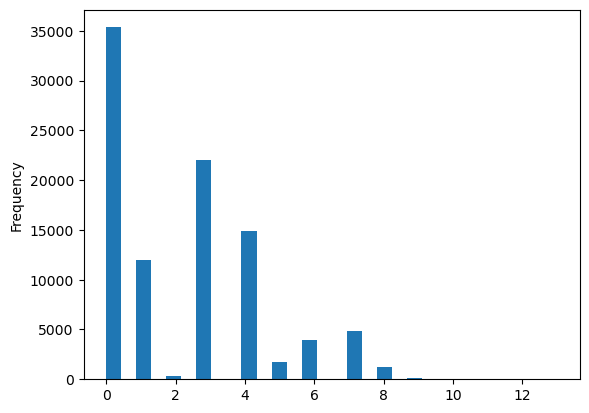

In [250]:
# save the results to a variable called probs
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 

Looking at this histogram, it is sensible to drop rows missing more than about 5 values on the basis that they are the ones that are most likely be problematic. We can use the index from probs to select out the rows we want to inspect from the main data frame.

In [251]:
print(f"df contains {df.shape[0]:,} rows.")
cutoff = 5
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows.")

df contains 96,651 rows.
df contains 86,466 rows.


#### 1.2.3. Fix Data Types

In [267]:
# Boolean
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


In [268]:
# Date
dates = ['first_review','last_review']
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

print(f"Now {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")

Currently last_review is of type 'object' 

Converting first_review
Converting last_review
Now last_review is of type 'datetime64[ns]' 



In [269]:
# categories
cats = ['property_type','room_type']
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

Currently room_type is of type 'object' 

Converting property_type
Converting room_type
Currently room_type is of type 'category' 



In [270]:
# These can be used for question 2: professional landlord
# compare with: calculated_host_listings_count,	
# calculated_host_listings_count_entire_homes,	
# calculated_host_listings_count_private_rooms,	
# calculated_host_listings_count_shared_rooms,	
print(df[cats[1]].cat.categories.values)
df[cats[0]].value_counts()
df[cats[1]].value_counts()

['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']


room_type
Entire home/apt    62456
Private room       33893
Shared room          191
Hotel room           111
Name: count, dtype: int64

In [255]:
# strings
money = ['price']
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


### JL - convert `bathroom_text` into integer 

In [ ]:
# string
bath_text = ['bathrooms_text']

### NOTE: JL - specify which columns need to be integer and check the float type

In [256]:
# integers
ints = ['id', 'listing_url', 'description', 'host_id', 'host_name', 'host_is_superhost',
        'host_listings_count', 'calculated_host_listings_count', 
                'calculated_host_listings_count_entire_homes', 'room_type', 'property_type',
                'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 'host_neighbourhood',
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'first_review', 'last_review']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting number_of_reviews_ltm
Converting estimated_occupancy_l365d
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting calculated_host_listings_count_private_rooms
Converting calculated_host_listings_count_shared_rooms


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86466 entries, 0 to 96650
Data columns (total 35 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            86466 non-null  int64         
 1   listing_url                                   86466 non-null  object        
 2   last_scraped                                  86466 non-null  datetime64[ns]
 3   name                                          86466 non-null  object        
 4   description                                   84356 non-null  object        
 5   host_id                                       86466 non-null  int64         
 6   host_name                                     86464 non-null  object        
 7   host_since                                    86466 non-null  datetime64[ns]
 8   host_location                                 65693 non-null  object   

### 1.3 Saving Clean Data

In [195]:
csv_out = Path(f'data/clean/{path.name}')
pq_out  = Path(f'data/clean/{path.name.replace('.csv.gz','.parquet')}')

if not csv_out.parent.exists():
    print(f"Creating {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)
    
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)
print(f"Saved {df.shape[0]:,} rows of {df.shape[1]:,} columns to {csv_out.resolve()}")
print("Done.")

Saved 85,816 rows of 32 columns to /home/jovyan/work/data/clean/20250615-London-listings.csv.gz
Done.


### Data filtering
JL - bathrooms	bathrooms_text
对比空值数量，选空值少的一列 

last_review，一年/两年数量对比，选择肘点

### 1.3 Create Geo-Data Frame

The current data we have is not Geo-Data yet, since the data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set. Therefore, we need to convert our coordinates into some kind of geo-data with `GeoPandas` package.

In [196]:
# Write data into Geo-data and
# set the crs into '4326'
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [197]:
# We check types of dataframes 
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[:5])

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
0    POINT (-0.01948 51.44306)
1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry
